# Marelle Board import
* Getting players info dict => `MarelleBoard.players`
* 3 phases : place, move and end => `MarelleBoard.phase`
* Reset the board => `MarelleBoard.initialize_game()`
* Printing the board => `MarelleBoard.print_board()`
* Id:Action dict => `MarelleBoard.id_to_action`
* Action:Id dict => `MarelleBoard.action_to_id`
* Get the board state => `MarelleBoard.get_state()`
* Play an action => `MarelleBoard.play_action(action_id, player)`
* Get legal action ids => `MarelleBoard.get_legal_action_ids(player)`
* Check if game ended (returns 0 if not ended or winning player id) : `MarelleBoard.check_if_end(player)`

In [7]:
import marl_env
import marl_agents
import marl_models
# importlib.reload(marl_env)
# importlib.reload(marl_agents)
# importlib.reload(marl_models)

from marl_env import MarelleBoard, MarelleGymEnv, MarelleGame
from marl_models import FCModel
from marl_agents import RandomAgent, BetterRandomAgent, Reinforce, Reinforce_place

import progressbar as pb
import numpy as np 
import importlib
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wandb

import torch
import torch.nn as nn

import sys
sys.path.insert(0, './utils')
from cliffwalk import CliffWalk


# Training agents

In [8]:
def train_agent(
    env,
    n_epochs,
    n_trajectories,
    trained_agent,
    opponent_agent,
    evaluate_agent,
    log_training=False,
    save_model_freq=50,
    evaluate_freq=25):

    if log_training:
        wandb.init(project="marl")
        wandb.config.n_trajectories = n_trajectories
        wandb.n_epochs = n_epochs

        # Trained agent
        wandb.config.trained_agent = trained_agent.__class__.__name__
        wandb.config.incentivize_captures = trained_agent.incentivize_captures
        wandb.config.punish_opponent_captures = trained_agent.punish_opponent_captures
        wandb.config.lr = trained_agent.lr
        wandb.config.optimizer_name = trained_agent.optimizer.__class__.__name__
        
        # Opponent agent
        wandb.config.opponent_agent = opponent_agent.__class__.__name__

        # Evaluation
        wandb.config.evaluation_agent = evaluate_agent.__class__.__name__

        # Model to watch metrics from
        if trained_agent.model != None :
            wandb.watch(trained_agent.model)
        
    trained_agent.train(n_trajectories, n_epochs, opponent_agent, evaluate_agent, log_training, save_model_freq, evaluate_freq)
    

### Test cliff

In [ ]:
#Timing du reward ?

go
Episode 1/40: rewards 1.01 +/- 1.23 - Loss : 5.949230670928955
Episode 2/40: rewards 1.03 +/- 1.2 - Loss : 5.83123779296875
Episode 3/40: rewards 1.07 +/- 1.32 - Loss : 6.681837558746338
Episode 4/40: rewards 1.24 +/- 1.6 - Loss : 9.417776107788086
Episode 5/40: rewards 1.4 +/- 2.0 - Loss : 13.509319305419922
Episode 6/40: rewards 1.43 +/- 2.02 - Loss : 13.731165885925293
Episode 7/40: rewards 2.13 +/- 22.86 - Loss : 39.82240676879883
Episode 8/40: rewards 1.68 +/- 2.38 - Loss : 18.6510066986084
Episode 9/40: rewards 1.8 +/- 2.44 - Loss : 19.826580047607422
Episode 10/40: rewards 2.07 +/- 2.76 - Loss : 25.387014389038086
Episode 11/40: rewards 2.16 +/- 2.86 - Loss : 27.208721160888672
Episode 12/40: rewards 2.28 +/- 3.02 - Loss : 30.05577278137207
Episode 13/40: rewards 2.37 +/- 2.91 - Loss : 29.23288345336914
Episode 14/40: rewards 2.99 +/- 22.87 - Loss : 51.34278869628906
Episode 15/40: rewards 2.59 +/- 3.17 - Loss : 34.4077262878418
Episode 16/40: rewards 2.7 +/- 3.29 - Loss : 36

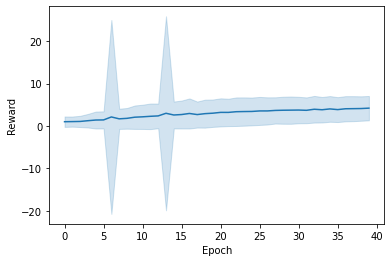

In [57]:
importlib.reload(marl_env)
importlib.reload(marl_agents)
importlib.reload(marl_models)
from marl_env import MarelleBoard, MarelleGymEnv, MarelleGame
from marl_models import FCModel
from marl_agents import RandomAgent, BetterRandomAgent, Reinforce, Reinforce_place, Reinforce_cliff

env = CliffWalk(proba_succ=0.98)
model = FCModel(2, env.Na)
print("go")
intel=Reinforce_cliff(env, model, lr=0.003)
intel.train(2000, 40, None, None, 1) #faire des trajectoires !!!
#rdlu

In [63]:
s=intel.env.reset()
obs=intel.env.render()
for i in range(20): 
    action = np.argmax(np.array(intel.model(torch.tensor([s,s],dtype=torch.float)).detach()))
    obs,reward,done,_=intel.env.step(action)
    #print("obs",obs in [37,38,39,40,41,42,43,44,45,46])
    #if(obs in [37,38,39,40,41,42,43,44,45,46]):
     #   done=True
     #   intel.env.render()
     #   intel.env.reset()
        
    print(["right","down","left","up"][action])
    print("state",obs)
    print("reward",reward)
    print("done",done)
    env.render()

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

up
state 24
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
up
state 12
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
up
state 0
reward 0.6
done False
+-----------------------+
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
up
state 0
reward 0.6
done False
+-----------------------+
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
up
state 0
reward 0.6
done False
+-----------------------

In [34]:
intel.env.reset()
obs=intel.env.render()
for i in range(3000): 
    if(obs==36):
        action=3
    else:
        if(obs==35):
            action=1
        else:
            action=0
    action=np.random.randint(0,4)
    obs,reward,done,_=intel.env.step(action)
    print("obs",obs in [37,38,39,40,41,42,43,44,45,46])
    if(obs in [37,38,39,40,41,42,43,44,45,46]):
        done=True
        intel.env.render()
        intel.env.reset()
        
    print(["right","down","left","up"][action])
    print("state",obs)
    print("reward",reward)
    print("done",done)
    env.render()

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

obs False
left
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
left
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
down
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs False
up
state 24
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs

state 2
reward 0.6
done False
+-----------------------+
| : :_: : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
left
state 1
reward 0.6
done False
+-----------------------+
| :_: : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
left
state 0
reward 0.6
done False
+-----------------------+
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
up
state 0
reward 0.6
done False
+-----------------------+
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs False
left
state 0
reward 0.6
done False
+-----------------------+
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+---

+-----------------------+
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
down
state 27
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs False
up
state 15
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs False
down
state 27
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs False
right
state 28
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : :_: : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (

reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
down
state 24
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs False
right
state 25
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| :_: : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
obs False
left
state 24
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
up
state 12
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+---

left
state 24
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
right
state 25
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| :_: : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
obs False
up
state 13
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| :_: : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs False
left
state 12
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
right
state 13
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| :_: : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:

done False
+-----------------------+
| : : : :_: : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs False
left
state 3
reward 0.6
done False
+-----------------------+
| : : :_: : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
down
state 15
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs False
down
state 27
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs False
left
state 26
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : :_: : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------

state 5
reward 0.6
done False
+-----------------------+
| : : : : :_: : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
down
state 17
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : :_: : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs False
left
state 16
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : :_: : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
down
state 28
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : :_: : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down

done False
+-----------------------+
| : : : : : : : : : : : |
| : :_: : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs False
right
state 15
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
obs False
left
state 14
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : :_: : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
down
state 26
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : :_: : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
down
state 38
rew

done False
+-----------------------+
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs False
left
state 12
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
down
state 24
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs False
left
state 24
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
left
state 24
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+----------------

up
state 12
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs False
down
state 24
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs False
up
state 12
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs False
up
state 0
reward 0.6
done False
+-----------------------+
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs False
up
state 0
reward 0.6
done False
+-----------------------+
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

obs False
down
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs False
down
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
right
state 37
reward 0.6
done True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

obs False
up
state 24
reward 0.6
done False
+--------

reward 0.6
done True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

obs False
down
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
right
state 37
reward 0.6
done True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

obs False
left
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs True
+----------------------

obs True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
right
state 37
reward 0.6
done True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

obs False
up
state 24
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs False
right
state 25
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| :_: : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
obs True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
down
state 37
reward 0.6
done True
+--

done False
+-----------------------+
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
obs False
left
state 14
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : :_: : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
down
state 26
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : :_: : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs False
up
state 14
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : :_: : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs False
up
state 2
reward 0.6
done False
+-----------------------+
| : :_: : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+--------------------

  (up)
obs False
right
state 1
reward 0.6
done False
+-----------------------+
| :_: : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
obs False
up
state 1
reward 0.6
done False
+-----------------------+
| :_: : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs False
left
state 0
reward 0.6
done False
+-----------------------+
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
left
state 1
reward 0.6
done False
+-----------------------+
| :_: : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
left
state 0
reward 0.6
done False
+-----------------------+
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x

down
state 37
reward 0.6
done True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

obs False
left
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
left
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
down
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs False
down
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : :_: |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
obs False
left
state 33
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : :_: : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
up
state 21
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : :_: : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs False
up
state 9
reward 0.6
done False
+-----------------------+
| : : : : : : : : :_: : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs False
up
state 9
reward 0.6
done False
+-----------------------+
| : : : : : : : : :_: : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
obs 

obs True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
down
state 37
reward 0.6
done True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

obs False
left
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
right
state 37
reward 0.6
done True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

obs True
+-----------------------+
| : : : : : : : : : 

  (down)
obs False
down
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs False
left
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
right
state 37
reward 0.6
done True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

obs False
left
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

obs True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
down
state 37
reward 0.6
done True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

obs False
down
state 36
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
right
state 37
reward 0.6
done True
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

obs False
down
state 36
reward 0.6
done False
+--------

down
state 12
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
obs False
right
state 13
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| :_: : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
obs False
right
state 14
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| : :_: : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
obs False
left
state 13
reward 0.6
done False
+-----------------------+
| : : : : : : : : : : : |
| :_: : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
obs False
up
state 1
reward 0.6
done False
+-----------------------+
| :_: : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:

### Marelle place phase

In [34]:
importlib.reload(marl_env)
importlib.reload(marl_agents)
importlib.reload(marl_models)
from marl_env import MarelleBoard, MarelleGymEnv, MarelleGame
from marl_models import FCModel, ConvModel
from marl_agents import RandomAgent, BetterRandomAgent, Reinforce, Reinforce_place

env = MarelleGymEnv()

einstein_model = FCModel(len(env.board.get_state()), len(env.board.id_to_action))
einstein_conv_model = ConvModel(566)


einstein=Reinforce_place(env, 1, einstein_model, lr=0.005, incentivize_captures=False, punish_opponent_captures=False)
einstein=Reinforce_place(env, 1, einstein_conv_model, lr=0.00005, incentivize_captures=False, punish_opponent_captures=False)


piccolo=BetterRandomAgent(env, -1)
gabi=RandomAgent(env,-1)
print("start training")
train_agent(
    env=env,
    n_epochs=300,
    n_trajectories=700,
    trained_agent=einstein,
    opponent_agent=gabi,
    evaluate_agent=gabi,
    log_training=False,
    save_model_freq=50,
    evaluate_freq=10
)

start training
Episode 5/300: rewards 0.05 +/- 1.25 - Loss : 2.613878011703491
Episode 10/300: rewards 0.03 +/- 1.26 - Loss : 1.4604101181030273
Episode 15/300: rewards -0.02 +/- 1.3 - Loss : -1.079338788986206
Episode 20/300: rewards 0.09 +/- 1.28 - Loss : 5.104188442230225
Episode 25/300: rewards 0.07 +/- 1.35 - Loss : 4.105569362640381
Episode 30/300: rewards 0.02 +/- 1.28 - Loss : 1.0359944105148315
Episode 35/300: rewards 0.05 +/- 1.27 - Loss : 2.892059803009033
Episode 40/300: rewards 0.07 +/- 1.28 - Loss : 3.9521052837371826
Episode 45/300: rewards 0.02 +/- 1.29 - Loss : 0.7647075653076172
Episode 50/300: rewards 0.15 +/- 1.29 - Loss : 8.492892265319824
Episode 55/300: rewards 0.06 +/- 1.25 - Loss : 3.3592052459716797
Episode 60/300: rewards 0.16 +/- 1.23 - Loss : 9.060400009155273
Episode 65/300: rewards 0.14 +/- 1.27 - Loss : 8.170500755310059
Episode 70/300: rewards 0.06 +/- 1.26 - Loss : 3.2295632362365723
Episode 75/300: rewards 0.01 +/- 1.25 - Loss : 0.3381842374801636
Epi

TypeError: 'numpy.float64' object is not iterable

In [ ]:
print("start training")
train_agent(
    env=env,
    n_epochs=500,
    n_trajectories=5000,
    trained_agent=einstein,
    opponent_agent=gabi,
    evaluate_agent=gabi,
    log_training=False,
    save_model_freq=50,
    evaluate_freq=10
)

start training
Episode 5/500: rewards 0.26 +/- 1.17 - Loss : 4.908871650695801
Episode 10/500: rewards 0.27 +/- 1.2 - Loss : 4.815968990325928
Episode 15/500: rewards 0.27 +/- 1.19 - Loss : 4.94525146484375
Episode 20/500: rewards 0.31 +/- 1.18 - Loss : 5.8011322021484375
Episode 25/500: rewards 0.3 +/- 1.19 - Loss : 5.382771968841553
Episode 30/500: rewards 0.28 +/- 1.17 - Loss : 4.984109878540039
Episode 35/500: rewards 0.24 +/- 1.19 - Loss : 3.8443679809570312
Episode 40/500: rewards 0.28 +/- 1.2 - Loss : 4.8934736251831055
Episode 45/500: rewards 0.3 +/- 1.17 - Loss : 5.1661529541015625
Episode 50/500: rewards 0.28 +/- 1.2 - Loss : 4.642369270324707
Episode 55/500: rewards 0.32 +/- 1.2 - Loss : 5.436619758605957
Episode 60/500: rewards 0.31 +/- 1.16 - Loss : 5.405096054077148
Episode 65/500: rewards 0.31 +/- 1.19 - Loss : 5.265673637390137
Episode 70/500: rewards 0.28 +/- 1.18 - Loss : 4.475854873657227
Episode 75/500: rewards 0.32 +/- 1.2 - Loss : 5.420974254608154
Episode 80/500:

In [ ]:
print("start training")
train_agent(
    env=env,
    n_epochs=500,
    n_trajectories=5000,
    trained_agent=einstein,
    opponent_agent=gabi,
    evaluate_agent=gabi,
    log_training=False,
    save_model_freq=50,
    evaluate_freq=10
)

## Restoring Models

In [5]:
def load_model(model_name, run_id, model):
    wandb.restore(model_name, run_path=f'clement-guillo/marl/{run_id}',root= "models/temp/")
    model.load_state_dict(torch.load(f'models/temp/{model_name}'))
    os.remove(f'models/temp/{model_name}')
    return(model)

# einstein_model=load_model('model_1_200.pt','d5zabrxq',FCModel(len(env.board.get_state()),len(env.board.id_to_action)))
# einstein=Reinforce(env, 1, einstein_model, lr=0.0001, incentivize_captures=False, punish_opponent_captures=False)


# Playing games

In [28]:
importlib.reload(marl_env)
importlib.reload(marl_agents)
importlib.reload(marl_models)
from marl_env import MarelleBoard, MarelleGymEnv, MarelleGame
from marl_models import FCModel
from marl_agents import RandomAgent, BetterRandomAgent, Reinforce

env = MarelleGymEnv()
piccolo = BetterRandomAgent(env, 1)

game = MarelleGame(env=env, player1=piccolo, player2=einstein)

In [29]:
action_history = game.play()

Reinforce_place 2's turn to play :

        Phase : place
        Placed tokens : P1 : 1 / P2 : 0 
        Tokens on board : P1 : 1 / P2 : 0 
        0--------------0--------------0
        |              |              |
        |    0---------0---------0    |
        |    |         |         |    |
        |    |    0----0----0    |    |
        |    |    |         |    |    |
        0----0----0         0----0----0                 
        |    |    |         |    |    |
        |    |    0----0----0    |    |
        |    |         |         |    |
        |    0---------0---------0    |
        |              |              |
        0--------------0--------------1
        


/Users/clementguillo/Desktop/MARL/marl_agents.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s=torch.tensor(s,dtype=torch.float)


ValueError: attempt to get argmax of an empty sequence

## Evaluating an agent by playing n_games

In [4]:
from marl_evaluations import evaluate

env = MarelleGymEnv()
piccolo = BetterRandomAgent(env, 1)
gabrielle = BetterRandomAgent(env, -1)

evaluation = evaluate(env, piccolo, gabrielle, 100, 1)
evaluation_2 = evaluate(env, piccolo, gabrielle, 1000, 1)
print(evaluation,evaluation_2)

{'n_actions': 56.22, 'n_captures_place': 0.33, 'n_captured_place': 0.35, 'n_captures_move': 3.76, 'n_captured_move': 4.37, 'draws_%': 0.0, 'victories_capture_%': 0.43, 'victories_block_%': 0.01, 'defeats_capture_%': 0.55, 'defeats_block_%': 0.01} {'n_actions': 56.146, 'n_captures_place': 0.266, 'n_captured_place': 0.238, 'n_captures_move': 3.8, 'n_captured_move': 4.453, 'draws_%': 0.0, 'victories_capture_%': 0.436, 'victories_block_%': 0.02, 'defeats_capture_%': 0.523, 'defeats_block_%': 0.021}


# Time test

Episode 5/10: rewards -0.64 +/- 0.77 - Loss : -79.2606430053711
Episode 10/10: rewards -0.58 +/- 0.81 - Loss : -67.5904312133789
         124927328 function calls (124617993 primitive calls) in 63.214 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        6    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(all)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(allclose)
        9    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(amax)
        8    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(amin)
      137    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(any)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(append)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(argsort)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(array_e

        3    0.000    0.000    0.002    0.001 _axes.py:1510(plot)
        1    0.000    0.000    0.000    0.000 _axes.py:196(get_xlabel)
        1    0.000    0.000    0.000    0.000 _axes.py:203(set_xlabel)
        1    0.000    0.000    0.000    0.000 _axes.py:249(get_ylabel)
        1    0.000    0.000    0.000    0.000 _axes.py:256(set_ylabel)
        1    0.000    0.000    0.000    0.000 _axes.py:302(get_legend_handles_labels)
        1    0.000    0.000    0.001    0.001 _axes.py:5097(_fill_between_x_or_y)
        2    0.000    0.000    0.000    0.000 _axes.py:5192(<genexpr>)
        1    0.000    0.000    0.001    0.001 _axes.py:5299(fill_between)
        1    0.000    0.000    0.016    0.016 _base.py:1038(cla)
        1    0.000    0.000    0.000    0.000 _base.py:1195(_set_title_offset_trans)
        1    0.000    0.000    0.000    0.000 _base.py:1432(set_box_aspect)
        2    0.000    0.000    0.000    0.000 _base.py:185(__init__)
        1    0.000    0.000    0.000    0.

       21    0.000    0.000    0.000    0.000 _ufunc_config.py:429(__init__)
       21    0.000    0.000    0.000    0.000 _ufunc_config.py:433(__enter__)
       21    0.000    0.000    0.000    0.000 _ufunc_config.py:438(__exit__)
        4    0.000    0.000    0.000    0.000 _validators.py:208(validate_bool_kwarg)
        2    0.000    0.000    0.000    0.000 _validators.py:218(validate_axis_style_args)
        9    0.000    0.000    0.000    0.000 abc.py:100(__subclasscheck__)
      454    0.000    0.000    0.000    0.000 abc.py:96(__instancecheck__)
    94836    0.072    0.000    0.787    0.000 activation.py:101(forward)
    47418    0.041    0.000    0.603    0.000 activation.py:1139(forward)
       10    0.001    0.000    0.004    0.000 adam.py:51(step)
       14    0.000    0.000    0.000    0.000 algorithms.py:1487(_get_take_nd_function)
       14    0.000    0.000    0.001    0.000 algorithms.py:1616(take_nd)
        3    0.000    0.000    0.000    0.000 algorithms.py:178(_rec

        1    0.000    0.000    0.000    0.000 base.py:2835(_assert_can_do_setop)
       21    0.000    0.000    0.001    0.000 base.py:2851(get_loc)
    50/22    0.001    0.000    0.003    0.000 base.py:293(__new__)
        2    0.000    0.000    0.000    0.000 base.py:2957(get_indexer)
        2    0.000    0.000    0.000    0.000 base.py:3115(_validate_positional_slice)
        1    0.000    0.000    0.000    0.000 base.py:3275(_can_reindex)
        1    0.000    0.000    0.000    0.000 base.py:3291(reindex)
       61    0.000    0.000    0.000    0.000 base.py:3870(_values)
       12    0.000    0.000    0.000    0.000 base.py:3896(_get_engine_target)
        2    0.000    0.000    0.000    0.000 base.py:3980(_coerce_scalar_to_index)
       36    0.000    0.000    0.000    0.000 base.py:4036(__contains__)
       21    0.000    0.000    0.000    0.000 base.py:4083(__getitem__)
      388    0.000    0.000    0.000    0.000 base.py:413(find)
        1    0.000    0.000    0.000    0.00

        1    0.000    0.000    0.000    0.000 concat.py:295(__init__)
        1    0.000    0.000    0.000    0.000 concat.py:379(<listcomp>)
        1    0.000    0.000    0.000    0.000 concat.py:456(get_result)
        1    0.000    0.000    0.000    0.000 concat.py:466(<listcomp>)
        1    0.000    0.000    0.000    0.000 concat.py:511(_get_result_dim)
        1    0.000    0.000    0.000    0.000 concat.py:517(_get_new_axes)
        1    0.000    0.000    0.000    0.000 concat.py:519(<listcomp>)
        1    0.000    0.000    0.000    0.000 concat.py:534(_get_concat_axis)
        1    0.000    0.000    0.000    0.000 concat.py:540(<listcomp>)
        1    0.000    0.000    0.000    0.000 concat.py:584(_maybe_check_integrity)
        1    0.000    0.000    0.000    0.000 concat.py:591(_concat_indexes)
        1    0.000    0.000    0.000    0.000 concat.py:70(concat)
       20    0.000    0.000    0.000    0.000 config.py:104(_get_option)
       20    0.000    0.000    0.000   

      137    0.000    0.000    0.000    0.000 fromnumeric.py:2245(_any_dispatcher)
      137    0.000    0.000    0.001    0.000 fromnumeric.py:2249(any)
        6    0.000    0.000    0.000    0.000 fromnumeric.py:2333(_all_dispatcher)
        6    0.000    0.000    0.000    0.000 fromnumeric.py:2337(all)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:2414(_cumsum_dispatcher)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:2418(cumsum)
        9    0.000    0.000    0.000    0.000 fromnumeric.py:2584(_amax_dispatcher)
        9    0.000    0.000    0.000    0.000 fromnumeric.py:2589(amax)
        8    0.000    0.000    0.000    0.000 fromnumeric.py:2709(_amin_dispatcher)
        8    0.000    0.000    0.000    0.000 fromnumeric.py:2714(amin)
        4    0.000    0.000    0.000    0.000 fromnumeric.py:2876(_prod_dispatcher)
        4    0.000    0.000    0.000    0.000 fromnumeric.py:2881(prod)
       10    0.000    0.000    0.000    0.000 fromnumeric.py:307

       60    0.000    0.000    0.000    0.000 lines.py:1175(set_markeredgewidth)
       60    0.000    0.000    0.001    0.000 lines.py:1190(set_markerfacecolor)
       60    0.000    0.000    0.001    0.000 lines.py:1204(set_markerfacecoloralt)
       60    0.000    0.000    0.000    0.000 lines.py:1218(set_markersize)
      141    0.000    0.000    0.000    0.000 lines.py:1232(set_xdata)
      150    0.000    0.000    0.000    0.000 lines.py:1244(set_ydata)
       39    0.000    0.000    0.001    0.000 lines.py:1277(update_from)
       60    0.000    0.000    0.000    0.000 lines.py:1302(set_dash_joinstyle)
       60    0.000    0.000    0.000    0.000 lines.py:1316(set_solid_joinstyle)
       60    0.000    0.000    0.000    0.000 lines.py:1346(set_dash_capstyle)
       60    0.000    0.000    0.000    0.000 lines.py:1360(set_solid_capstyle)
        1    0.000    0.000    0.000    0.000 lines.py:1382(get_solid_capstyle)
       60    0.001    0.000    0.008    0.000 lines.py:269(__in

        1    0.000    0.000    0.000    0.000 numeric.py:164(_union)
        1    0.000    0.000    0.000    0.000 numeric.py:2117(_allclose_dispatcher)
        1    0.000    0.000    0.000    0.000 numeric.py:2121(allclose)
        1    0.000    0.000    0.000    0.000 numeric.py:2193(_isclose_dispatcher)
        1    0.000    0.000    0.000    0.000 numeric.py:2197(isclose)
        1    0.000    0.000    0.000    0.000 numeric.py:2274(within_tol)
        3    0.000    0.000    0.000    0.000 numeric.py:2313(_array_equal_dispatcher)
        3    0.000    0.000    0.000    0.000 numeric.py:2317(array_equal)
        2    0.000    0.000    0.000    0.000 numeric.py:237(inferred_type)
        2    0.000    0.000    0.000    0.000 numeric.py:268(full)
        1    0.000    0.000    0.000    0.000 numeric.py:271(_is_compatible_with_other)
        5    0.000    0.000    0.000    0.000 numeric.py:50(__new__)
        2    0.000    0.000    0.000    0.000 numeric.py:71(_zeros_like_dispatcher)
 

       26    0.000    0.000    0.000    0.000 shape_base.py:608(_column_stack_dispatcher)
       26    0.000    0.000    0.000    0.000 shape_base.py:612(column_stack)
        4    0.000    0.000    0.000    0.000 shape_base.py:78(_atleast_2d_dispatcher)
        4    0.000    0.000    0.000    0.000 shape_base.py:82(atleast_2d)
        1    0.000    0.000    0.000    0.000 shutil.py:1298(get_terminal_size)
        6    0.000    0.000    0.000    0.000 socket.py:357(send)
        2    0.000    0.000    0.000    0.000 sorting.py:112(get_compressed_ids)
        1    0.000    0.000    0.000    0.000 sorting.py:182(indexer_from_factorized)
        1    0.000    0.000    0.001    0.001 sorting.py:194(lexsort_indexer)
        1    0.000    0.000    0.000    0.000 sorting.py:226(<listcomp>)
        3    0.000    0.000    0.000    0.000 sorting.py:23(get_group_index)
        2    0.000    0.000    0.000    0.000 sorting.py:392(ensure_key_mapped)
        1    0.000    0.000    0.000    0.000 sor

       16    0.000    0.000    0.000    0.000 weakref.py:44(__new__)
        6    0.000    0.000    0.000    0.000 weakref.py:51(_cb)
        2    0.000    0.000    0.000    0.000 weakref.py:73(__eq__)
        4    0.000    0.000    0.000    0.000 well_known_types.py:197(GetCurrentTime)
        4    0.000    0.000    0.000    0.000 well_known_types.py:245(FromDatetime)
        2    0.000    0.000    0.000    0.000 widgets.py:35(__init__)
      200    0.000    0.000    0.000    0.000 {built-in method __new__ of type object at 0x102e4d808}
      454    0.000    0.000    0.000    0.000 {built-in method _abc._abc_instancecheck}
        9    0.000    0.000    0.000    0.000 {built-in method _abc._abc_subclasscheck}
        1    0.000    0.000    0.000    0.000 {built-in method _functools.reduce}
        1    0.000    0.000    0.000    0.000 {built-in method _operator.add}
        4    0.000    0.000    0.000    0.000 {built-in method _operator.index}
        3    0.000    0.000    0.000    

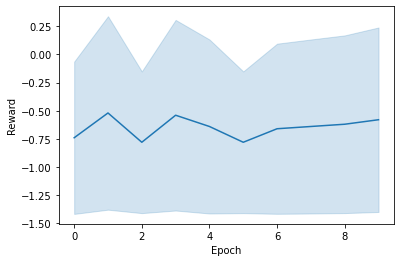

In [13]:
import cProfile
env = MarelleGymEnv()

einstein_model = FCModel(len(env.board.get_state()), len(env.board.id_to_action))

einstein=Reinforce(env, 1, einstein_model, lr=0.005, incentivize_captures=False, punish_opponent_captures=False)

piccolo=BetterRandomAgent(env, -1)


cProfile.run("""train_agent(
    env=env,
    n_epochs=10,
    n_trajectories=100,
    trained_agent=einstein,
    opponent_agent=piccolo,
    log_training=False
)""")